In [1]:
#!pip uninstall --yes gdown # After running this line, restart Colab runtime.
#!pip install --upgrade --no-cache-dir gdown
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 16.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [2]:
#import gdown
#url = "https://drive.google.com/drive/folders/1NNVry5TnTsiPIAh3bupQOmGw5NIuDbF0"

#gdown.download_folder(url, quiet=True, use_cookies=True, remaining_ok=True)


**link to preprocessed dataset temporal differences** : https://drive.google.com/drive/folders/19HbCp0bfK0S0ZhEuEs3sVo1PZdhXt3R4?usp=sharing.


**link to preprocessed dataset mel spectogram** : https://drive.google.com/drive/folders/1Iy6zGulBbHbe9S3LbqEE1Etftes_XfyG?usp=share_link

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [139]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import shutil
import torch
import torchmetrics
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score
from torch.utils.data import Dataset, DataLoader,  SubsetRandomSampler,random_split
from torchvision import transforms
from tqdm import tqdm


In [293]:
seed = 8
np.random.seed(seed)
random.seed(seed)

In [294]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training on: {device}')

Training on: cuda


In [295]:
class OGLE3SpectrogramDataset(Dataset):
    def __init__(self, root_dir, min_files=200, load_from=None):
        """
        Initializes the dataset.
        Args:
            root_dir (str): Directory containing all the spectrogram files.
            min_files (int): Minimum number of files per class to be included in the dataset.
            load_from (str, optional): Path to load the dataset from if previously saved.
        """
        self.root_dir = root_dir
        self.min_files = min_files

        if load_from:
            self.data, self.labels = self.load_dataset(load_from)
        else:
            self.data, self.labels = self.load_data()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if idx < len(self.data):
            return {'data': self.data[idx], 'label': self.labels[idx]}
        else:
            return {'data': None, 'label': None}

    def load_data(self):
        data = []
        labels = []
        label_encoder = LabelEncoder()
        class_folders = [folder for folder in os.listdir(self.root_dir) if os.path.isdir(os.path.join(self.root_dir, folder))]

        for folder in tqdm(class_folders, desc="Loading data"):
            class_path = os.path.join(self.root_dir, folder)
            files = [f for f in os.listdir(class_path) if f.endswith('.pt')]
            if len(files) >= self.min_files:
                class_label = folder.split('_')[0]
                for file_name in files:
                    file_path = os.path.join(class_path, file_name)
                    try:
                        spectrogram_tensor = torch.load(file_path)
                        data.append(spectrogram_tensor)
                        labels.append(class_label)
                    except Exception as e:
                        print(f"Error loading spectrogram {file_path}: {e}")

        if labels:
            labels = label_encoder.fit_transform(labels)
            labels = torch.tensor(labels, dtype=torch.long)

        return data, labels

    def save_dataset(self, save_path):
        torch.save({
            'data': self.data,
            'labels': self.labels
        }, save_path)

    @staticmethod
    def load_dataset(load_path):
        checkpoint = torch.load(load_path)
        data = checkpoint['data']
        labels = checkpoint['labels']
        return data, labels




In [296]:
#path = '/content/drive/MyDrive/ADV_ML/OGLE3_Spectrogram/t2cep_preprocessed/OGLE-BLG-T2CEP-283_augmented_1_preprocessed_spectrogram.pt'
#specto_test= torch.load(path)
#specto_test.shape

In [297]:
root_folder = '/content/drive/MyDrive/ADV_ML/OGLE3_Spectrogram_2'
save_path = '/content/drive/MyDrive/ADV_ML/saved_OGLE3_Spectrogram_2.pth'

In [298]:
# Creating and saving the dataset
#dataset_specto = OGLE3SpectrogramDataset(root_folder)

In [299]:
loaded_dataset_specto = OGLE3SpectrogramDataset(root_dir=root_folder, load_from=save_path)

##train resnet on spectogramm red flag

In [300]:
"""
def train_model(model, dataset, num_epochs=10, batch_size=32):
    print(f"running on {device}")
    skf = StratifiedKFold(n_splits=10, shuffle=True)
    accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=9, average='weighted').to(device)
    f1_metric = torchmetrics.F1Score(task="multiclass", num_classes=9, average='weighted').to(device)

    fold_accuracies = []
    fold_f1_scores = []

    for fold, (train_indices, val_indices) in enumerate(skf.split(dataset.file_paths, [label for _, label in dataset.file_paths])):
        train_sampler = SubsetRandomSampler(train_indices)
        val_sampler = SubsetRandomSampler(val_indices)
        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
        val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        epoch_accuracies = []
        epoch_f1_scores = []

        for epoch in tqdm(range(num_epochs), desc=f'Fold {fold+1}'):
            model.train()
            running_loss = 0.0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            model.eval()
            accuracy_metric.reset()
            f1_metric.reset()
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    accuracy_metric.update(outputs, labels)
                    f1_metric.update(outputs, labels)

            epoch_accuracies.append(accuracy_metric.compute().item())
            epoch_f1_scores.append(f1_metric.compute().item())

            print(f'Fold {fold+1}, Epoch {epoch+1}: Validation Weighted Accuracy: {epoch_accuracies[-1]}, Validation Weighted F1 Score: {epoch_f1_scores[-1]}')

        fold_accuracies.append(epoch_accuracies)
        fold_f1_scores.append(epoch_f1_scores)

    # Plotting the results
    plt.figure(figsize=(10, 8))
    for i in range(10):
        plt.subplot(2, 1, 1)
        plt.plot(range(1, num_epochs + 1), fold_accuracies[i], label=f'Fold {i+1}')
        plt.title('Validation Weighted Accuracy per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Weighted Accuracy')
        plt.legend(loc='upper left')
        plt.grid(True)

        plt.subplot(2, 1, 2)
        plt.plot(range(1, num_epochs + 1), fold_f1_scores[i], label=f'Fold {i+1}')
        plt.title('Validation Weighted F1 Score per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Weighted F1 Score')
        plt.legend(loc='upper left')
        plt.grid(True)

    plt.tight_layout()
    plt.show()

    return fold_accuracies, fold_f1_scores
"""

'\ndef train_model(model, dataset, num_epochs=10, batch_size=32):\n    print(f"running on {device}")\n    skf = StratifiedKFold(n_splits=10, shuffle=True)\n    accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=9, average=\'weighted\').to(device)\n    f1_metric = torchmetrics.F1Score(task="multiclass", num_classes=9, average=\'weighted\').to(device)\n\n    fold_accuracies = []\n    fold_f1_scores = []\n\n    for fold, (train_indices, val_indices) in enumerate(skf.split(dataset.file_paths, [label for _, label in dataset.file_paths])):\n        train_sampler = SubsetRandomSampler(train_indices)\n        val_sampler = SubsetRandomSampler(val_indices)\n        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)\n        val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)\n\n        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)\n        criterion = nn.CrossEntropyLoss()\n\n        epoch_accuracies = []\n 

##train resnet on spectogramm

In [301]:
from torchvision import models, transforms

In [302]:
# Assuming `dataset` is your dataset instance
train_size = int(0.8 * len(loaded_dataset_specto))
val_size = len(loaded_dataset_specto) - train_size
train_dataset, val_dataset = random_split(loaded_dataset_specto, [train_size, val_size])
batch_size =64
batch_size_val = 64*2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers =4)
val_loader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False, num_workers =4)

In [303]:
def train_model(model, optimizer, scheduler, train_loader, val_loader, model_name, num_epochs=10, save_path='models/'):
    """
    Train and validate a PyTorch model, saving the best and last model states.

    Args:
        model: PyTorch model to train.
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        num_epochs: Number of epochs to train (default 10).
        save_path: Path to save the model files (default 'models/').

    Returns:
        A dictionary containing training and validation accuracy, F1 scores, and losses.
    """
    print(f"Running on {device}")

    # Metrics
    accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=9, average='weighted').to(device)
    f1_metric = torchmetrics.F1Score(task="multiclass", num_classes=9, average='weighted').to(device)
    criterion = nn.CrossEntropyLoss().to(device)

    # To store metrics history and best model
    train_accuracies, train_f1_scores, val_accuracies, val_f1_scores = [], [], [], []
    train_losses, val_losses = [], []
    best_val_f1 = 0

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        train_accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=9, average='weighted').to(device)
        train_f1_metric = torchmetrics.F1Score(task="multiclass", num_classes=9, average='weighted').to(device)
        total_train_loss = 0

        for batch in tqdm(train_loader, desc=f'Training, Epoch {epoch + 1}', leave=False):
            inputs, labels = batch['data'].to(device), batch['label'].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * inputs.size(0)
            train_accuracy_metric.update(outputs, labels)
            train_f1_metric.update(outputs, labels)

        train_acc = train_accuracy_metric.compute().item()
        train_f1 = train_f1_metric.compute().item()
        train_losses.append(total_train_loss / len(train_loader.dataset))
        train_accuracies.append(train_acc)
        train_f1_scores.append(train_f1)

        scheduler.step()

        # Validation Phase
        model.eval()
        accuracy_metric.reset()
        f1_metric.reset()
        total_val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f'Validating, Epoch {epoch + 1}', leave=False):
                inputs, labels = batch['data'].to(device), batch['label'].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item() * inputs.size(0)
                accuracy_metric.update(outputs, labels)
                f1_metric.update(outputs, labels)

        val_acc = accuracy_metric.compute().item()
        val_f1 = f1_metric.compute().item()
        val_losses.append(total_val_loss / len(val_loader.dataset))
        val_accuracies.append(val_acc)
        val_f1_scores.append(val_f1)

        # Checkpoint the best model
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), f"{save_path}{model_name}_best.pth")
            #print(f"Saved best model with accuracy: {best_val_f1:.3f}")

        print(f'Epoch {epoch+1}: Train_loss: {train_losses[-1]:.3f}, Train_Acc: {train_acc:.3f}, Train_F1: {train_f1:.3f}, Val_loss: {val_losses[-1]:.3f}, Val_Acc: {val_acc:.3f}, Val_F1: {val_f1:.3f}')

    # Save the last model state
    torch.save(model.state_dict(), f"{save_path}{model_name}_last.pth")
    print("Saved last model state")

    # Plotting the results
    plt.figure(figsize=(12, 12))
    plt.subplot(3, 1, 1)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.plot(range(1, num_epochs + 1), train_f1_scores, label='Train F1 Score')
    plt.plot(range(1, num_epochs + 1), val_f1_scores, label='Validation F1 Score')
    plt.title('F1 Score per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend(loc='upper left')
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return {
        'train_accuracies': train_accuracies,
        'train_f1_scores': train_f1_scores,
        'val_accuracies': val_accuracies,
        'val_f1_scores': val_f1_scores,
        'train_losses': train_losses,
        'val_losses': val_losses
    }


In [304]:
model_resnet = models.resnet18(pretrained=True)
#model_resnet

In [305]:
#num_classes = len(dataset_specto.class_to_idx)
num_classes =9

In [306]:
#num_classes = len(dataset_specto.class_to_idx)
model_resnet.conv1 = nn.Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_features = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_features, num_classes)  # Adjusting the final layer for 9 classes
model_resnet = model_resnet.to(device)
model_resnet


ResNet(
  (conv1): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

optimizer

In [307]:
optimizer = torch.optim.Adam(model_resnet.parameters(), lr=0.0005)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)



Running on cuda


Epoch 1: Train_loss: 1.373, Train_Acc: 0.474, Train_F1: 0.453, Val_loss: 2.066, Val_Acc: 0.318, Val_F1: 0.282


Epoch 2: Train_loss: 1.085, Train_Acc: 0.596, Train_F1: 0.575, Val_loss: 3.076, Val_Acc: 0.216, Val_F1: 0.148


Epoch 3: Train_loss: 0.897, Train_Acc: 0.668, Train_F1: 0.652, Val_loss: 2.222, Val_Acc: 0.319, Val_F1: 0.316


Epoch 4: Train_loss: 0.726, Train_Acc: 0.730, Train_F1: 0.720, Val_loss: 2.832, Val_Acc: 0.202, Val_F1: 0.122


Epoch 5: Train_loss: 0.606, Train_Acc: 0.777, Train_F1: 0.772, Val_loss: 2.555, Val_Acc: 0.320, Val_F1: 0.287


Epoch 6: Train_loss: 0.530, Train_Acc: 0.804, Train_F1: 0.801, Val_loss: 3.366, Val_Acc: 0.231, Val_F1: 0.148


Epoch 7: Train_loss: 0.463, Train_Acc: 0.828, Train_F1: 0.826, Val_loss: 3.451, Val_Acc: 0.230, Val_F1: 0.160


Epoch 8: Train_loss: 0.302, Train_Acc: 0.891, Train_F1: 0.890, Val_loss: 1.166, Val_Acc: 0.659, Val_F1: 0.673


Epoch 9: Train_loss: 0.253, Train_Acc: 0.908, Train_F1: 0.908, Val_loss: 0.931, Val_Acc: 0.721, Val_F1: 0.722


Epoch 10: Train_loss: 0.227, Train_Acc: 0.917, Train_F1: 0.917, Val_loss: 1.099, Val_Acc: 0.698, Val_F1: 0.705


Epoch 11: Train_loss: 0.200, Train_Acc: 0.928, Train_F1: 0.928, Val_loss: 2.484, Val_Acc: 0.417, Val_F1: 0.428


Epoch 12: Train_loss: 0.180, Train_Acc: 0.936, Train_F1: 0.935, Val_loss: 1.085, Val_Acc: 0.706, Val_F1: 0.708


Epoch 13: Train_loss: 0.164, Train_Acc: 0.941, Train_F1: 0.941, Val_loss: 0.940, Val_Acc: 0.738, Val_F1: 0.739


Epoch 14: Train_loss: 0.147, Train_Acc: 0.948, Train_F1: 0.948, Val_loss: 0.695, Val_Acc: 0.804, Val_F1: 0.802


Epoch 15: Train_loss: 0.122, Train_Acc: 0.957, Train_F1: 0.957, Val_loss: 0.829, Val_Acc: 0.772, Val_F1: 0.771


Epoch 16: Train_loss: 0.117, Train_Acc: 0.959, Train_F1: 0.959, Val_loss: 0.607, Val_Acc: 0.828, Val_F1: 0.826


Epoch 17: Train_loss: 0.111, Train_Acc: 0.961, Train_F1: 0.961, Val_loss: 0.735, Val_Acc: 0.803, Val_F1: 0.801


Epoch 18: Train_loss: 0.107, Train_Acc: 0.962, Train_F1: 0.962, Val_loss: 0.769, Val_Acc: 0.796, Val_F1: 0.794


Epoch 19: Train_loss: 0.104, Train_Acc: 0.963, Train_F1: 0.963, Val_loss: 0.899, Val_Acc: 0.767, Val_F1: 0.768


Epoch 20: Train_loss: 0.105, Train_Acc: 0.964, Train_F1: 0.964, Val_loss: 0.948, Val_Acc: 0.755, Val_F1: 0.756


Epoch 21: Train_loss: 0.102, Train_Acc: 0.966, Train_F1: 0.966, Val_loss: 1.672, Val_Acc: 0.607, Val_F1: 0.618


Epoch 22: Train_loss: 0.099, Train_Acc: 0.965, Train_F1: 0.965, Val_loss: 1.454, Val_Acc: 0.656, Val_F1: 0.666


Epoch 23: Train_loss: 0.098, Train_Acc: 0.967, Train_F1: 0.967, Val_loss: 0.835, Val_Acc: 0.782, Val_F1: 0.781


Epoch 24: Train_loss: 0.097, Train_Acc: 0.967, Train_F1: 0.967, Val_loss: 1.664, Val_Acc: 0.610, Val_F1: 0.624


Epoch 25: Train_loss: 0.098, Train_Acc: 0.966, Train_F1: 0.966, Val_loss: 1.295, Val_Acc: 0.687, Val_F1: 0.696


Epoch 26: Train_loss: 0.098, Train_Acc: 0.966, Train_F1: 0.966, Val_loss: 0.834, Val_Acc: 0.785, Val_F1: 0.784


Epoch 27: Train_loss: 0.098, Train_Acc: 0.965, Train_F1: 0.965, Val_loss: 0.649, Val_Acc: 0.824, Val_F1: 0.822


Epoch 28: Train_loss: 0.097, Train_Acc: 0.967, Train_F1: 0.967, Val_loss: 2.495, Val_Acc: 0.487, Val_F1: 0.501


Epoch 29: Train_loss: 0.097, Train_Acc: 0.966, Train_F1: 0.966, Val_loss: 0.721, Val_Acc: 0.809, Val_F1: 0.808


Epoch 30: Train_loss: 0.097, Train_Acc: 0.967, Train_F1: 0.967, Val_loss: 0.804, Val_Acc: 0.797, Val_F1: 0.796


Epoch 31: Train_loss: 0.097, Train_Acc: 0.966, Train_F1: 0.966, Val_loss: 0.569, Val_Acc: 0.836, Val_F1: 0.835


Epoch 32: Train_loss: 0.100, Train_Acc: 0.965, Train_F1: 0.965, Val_loss: 0.903, Val_Acc: 0.765, Val_F1: 0.766


Epoch 33: Train_loss: 0.094, Train_Acc: 0.967, Train_F1: 0.967, Val_loss: 0.883, Val_Acc: 0.769, Val_F1: 0.769


Epoch 34: Train_loss: 0.098, Train_Acc: 0.966, Train_F1: 0.966, Val_loss: 1.098, Val_Acc: 0.722, Val_F1: 0.726


Epoch 35: Train_loss: 0.097, Train_Acc: 0.966, Train_F1: 0.966, Val_loss: 1.246, Val_Acc: 0.700, Val_F1: 0.706


Epoch 36: Train_loss: 0.099, Train_Acc: 0.966, Train_F1: 0.966, Val_loss: 1.049, Val_Acc: 0.734, Val_F1: 0.737


Epoch 37: Train_loss: 0.098, Train_Acc: 0.966, Train_F1: 0.966, Val_loss: 2.341, Val_Acc: 0.503, Val_F1: 0.516


Epoch 38: Train_loss: 0.096, Train_Acc: 0.967, Train_F1: 0.967, Val_loss: 1.691, Val_Acc: 0.613, Val_F1: 0.625


Epoch 39: Train_loss: 0.096, Train_Acc: 0.967, Train_F1: 0.967, Val_loss: 0.756, Val_Acc: 0.799, Val_F1: 0.799


Epoch 40: Train_loss: 0.095, Train_Acc: 0.968, Train_F1: 0.968, Val_loss: 1.288, Val_Acc: 0.684, Val_F1: 0.692


Epoch 41: Train_loss: 0.096, Train_Acc: 0.967, Train_F1: 0.967, Val_loss: 0.631, Val_Acc: 0.828, Val_F1: 0.826


Epoch 42: Train_loss: 0.098, Train_Acc: 0.966, Train_F1: 0.966, Val_loss: 1.295, Val_Acc: 0.685, Val_F1: 0.692


Epoch 43: Train_loss: 0.096, Train_Acc: 0.967, Train_F1: 0.967, Val_loss: 0.646, Val_Acc: 0.827, Val_F1: 0.826


Epoch 44: Train_loss: 0.095, Train_Acc: 0.967, Train_F1: 0.967, Val_loss: 0.987, Val_Acc: 0.742, Val_F1: 0.744


Epoch 45: Train_loss: 0.095, Train_Acc: 0.967, Train_F1: 0.967, Val_loss: 1.155, Val_Acc: 0.714, Val_F1: 0.719


Epoch 46: Train_loss: 0.096, Train_Acc: 0.967, Train_F1: 0.967, Val_loss: 0.639, Val_Acc: 0.828, Val_F1: 0.826


Epoch 47: Train_loss: 0.097, Train_Acc: 0.966, Train_F1: 0.966, Val_loss: 1.757, Val_Acc: 0.600, Val_F1: 0.613


Epoch 48: Train_loss: 0.097, Train_Acc: 0.966, Train_F1: 0.966, Val_loss: 1.856, Val_Acc: 0.587, Val_F1: 0.603


Epoch 49: Train_loss: 0.098, Train_Acc: 0.966, Train_F1: 0.966, Val_loss: 1.059, Val_Acc: 0.732, Val_F1: 0.735


Epoch 50: Train_loss: 0.095, Train_Acc: 0.968, Train_F1: 0.968, Val_loss: 0.583, Val_Acc: 0.837, Val_F1: 0.836


Epoch 51: Train_loss: 0.096, Train_Acc: 0.968, Train_F1: 0.968, Val_loss: 0.779, Val_Acc: 0.797, Val_F1: 0.796


Epoch 52: Train_loss: 0.096, Train_Acc: 0.967, Train_F1: 0.967, Val_loss: 0.685, Val_Acc: 0.821, Val_F1: 0.819


Epoch 53: Train_loss: 0.096, Train_Acc: 0.968, Train_F1: 0.968, Val_loss: 1.580, Val_Acc: 0.634, Val_F1: 0.648


Epoch 54: Train_loss: 0.097, Train_Acc: 0.966, Train_F1: 0.966, Val_loss: 1.217, Val_Acc: 0.702, Val_F1: 0.709


Epoch 55: Train_loss: 0.097, Train_Acc: 0.967, Train_F1: 0.967, Val_loss: 0.879, Val_Acc: 0.772, Val_F1: 0.772


Epoch 56: Train_loss: 0.095, Train_Acc: 0.967, Train_F1: 0.967, Val_loss: 0.594, Val_Acc: 0.835, Val_F1: 0.834


Epoch 57: Train_loss: 0.094, Train_Acc: 0.967, Train_F1: 0.967, Val_loss: 0.968, Val_Acc: 0.747, Val_F1: 0.749


Epoch 58: Train_loss: 0.096, Train_Acc: 0.966, Train_F1: 0.966, Val_loss: 0.766, Val_Acc: 0.801, Val_F1: 0.800


Epoch 59: Train_loss: 0.095, Train_Acc: 0.967, Train_F1: 0.967, Val_loss: 1.186, Val_Acc: 0.705, Val_F1: 0.710


Epoch 60: Train_loss: 0.096, Train_Acc: 0.967, Train_F1: 0.967, Val_loss: 0.795, Val_Acc: 0.796, Val_F1: 0.796


Epoch 61: Train_loss: 0.099, Train_Acc: 0.966, Train_F1: 0.966, Val_loss: 0.684, Val_Acc: 0.816, Val_F1: 0.815


Epoch 62: Train_loss: 0.098, Train_Acc: 0.967, Train_F1: 0.967, Val_loss: 1.577, Val_Acc: 0.631, Val_F1: 0.644


Epoch 63: Train_loss: 0.094, Train_Acc: 0.967, Train_F1: 0.967, Val_loss: 1.005, Val_Acc: 0.745, Val_F1: 0.746


Epoch 64: Train_loss: 0.096, Train_Acc: 0.967, Train_F1: 0.967, Val_loss: 0.748, Val_Acc: 0.809, Val_F1: 0.807
Saved last model state


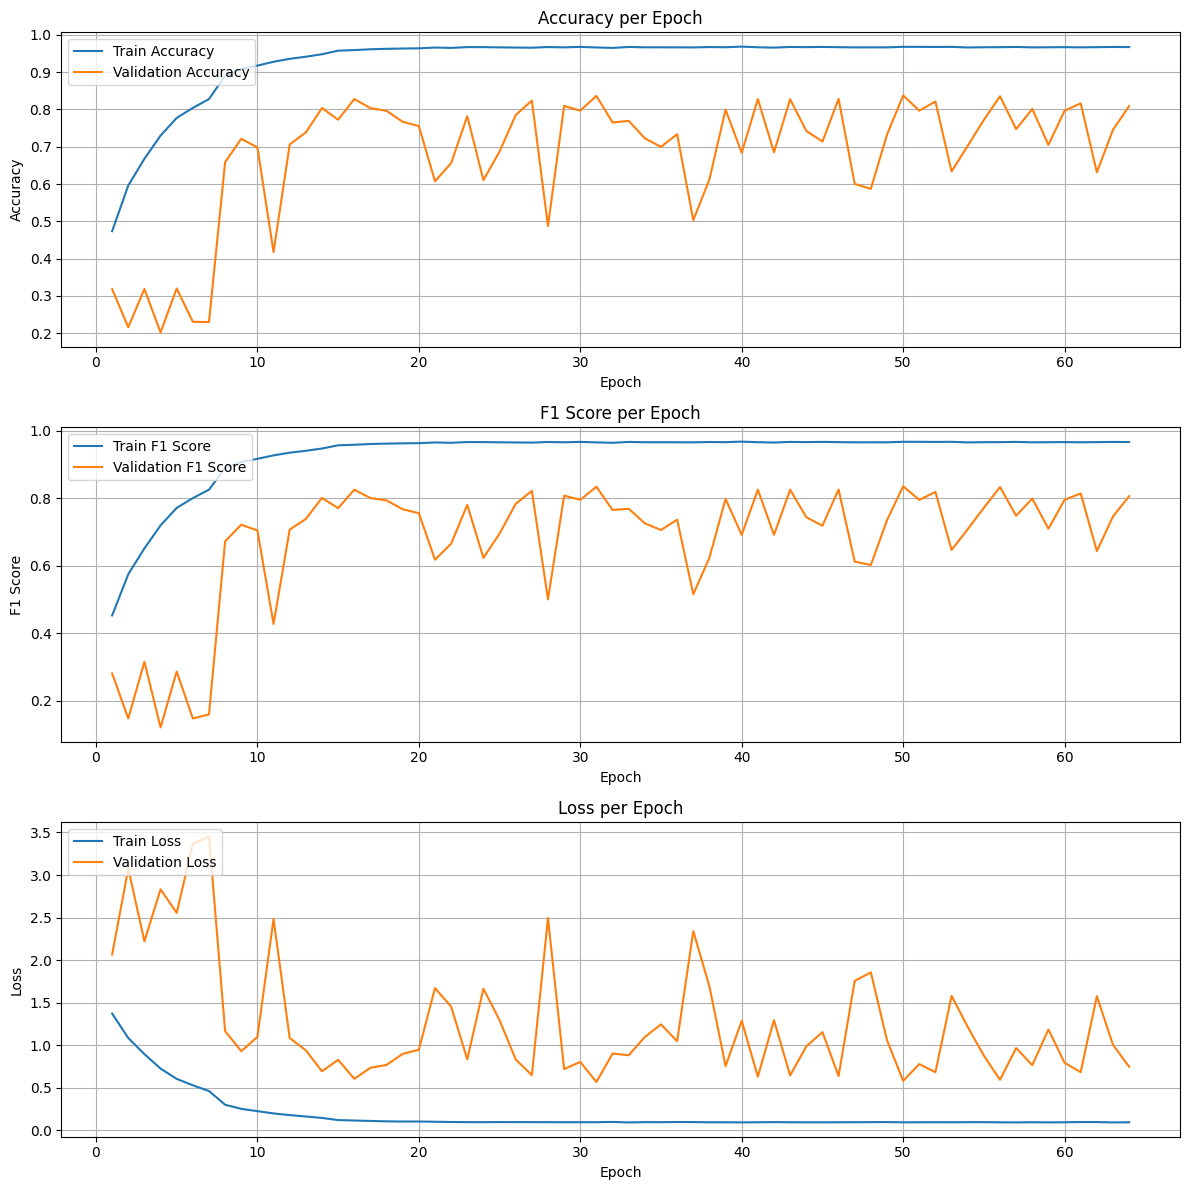

In [308]:
model_name = 'model_resnet'
path = '/content/drive/MyDrive/ADV_ML/'
results_resnet = train_model(model_resnet, optimizer, exp_lr_scheduler, train_loader, val_loader, model_name, 64, path)


##resnet with dropout

In [364]:
model_resnet2 = models.resnet18(pretrained=True)

In [365]:
class BasicBlockWithDropout(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlockWithDropout, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.5)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.dropout(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


In [366]:
def replace_layers(model, block):
    for name, module in model.named_children():
        if isinstance(module, models.resnet.BasicBlock):
            setattr(model, name, block(module.conv1.in_channels,
                                       module.conv2.out_channels,
                                       module.stride,
                                       module.downsample))
        elif "layer" in name:
            # Replace all basic blocks in each layer
            for name2, sub_module in module.named_children():
                if isinstance(sub_module, models.resnet.BasicBlock):
                    module[int(name2)] = block(sub_module.conv1.in_channels,
                                               sub_module.conv2.out_channels,
                                               sub_module.stride,
                                               sub_module.downsample)
        else:
            replace_layers(module, block)



In [367]:
replace_layers(model_resnet2, BasicBlockWithDropout)

In [368]:
num_ftrs = model_resnet2.fc.in_features
model_resnet2.fc = nn.Linear(num_ftrs, 9)  # Adjust for your number of classes
model_resnet2.conv1 = nn.Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


In [369]:
#for param in model_resnet2.parameters():
#    param.requires_grad = False

#model_resnet2.fc.requires_grad = True  # Ensure the fc layer's weights are trainable


In [370]:
model_resnet2 = model_resnet2.to(device)
model_resnet2

ResNet(
  (conv1): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlockWithDropout(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (dropout): Dropout(p=0.5, inplace=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlockWithDropout(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [371]:
optimizer = torch.optim.Adam(model_resnet2.parameters(), lr=0.0004)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)


Running on cuda


Epoch 1: Train_loss: 1.830, Train_Acc: 0.235, Train_F1: 0.223, Val_loss: 1.705, Val_Acc: 0.306, Val_F1: 0.232


Epoch 2: Train_loss: 1.444, Train_Acc: 0.437, Train_F1: 0.418, Val_loss: 1.573, Val_Acc: 0.399, Val_F1: 0.354


Epoch 3: Train_loss: 1.300, Train_Acc: 0.481, Train_F1: 0.464, Val_loss: 1.401, Val_Acc: 0.445, Val_F1: 0.431


Epoch 4: Train_loss: 1.251, Train_Acc: 0.501, Train_F1: 0.483, Val_loss: 1.775, Val_Acc: 0.306, Val_F1: 0.272


Epoch 5: Train_loss: 1.195, Train_Acc: 0.532, Train_F1: 0.514, Val_loss: 1.692, Val_Acc: 0.317, Val_F1: 0.284


Epoch 6: Train_loss: 1.133, Train_Acc: 0.557, Train_F1: 0.540, Val_loss: 1.069, Val_Acc: 0.576, Val_F1: 0.552


Epoch 7: Train_loss: 1.054, Train_Acc: 0.593, Train_F1: 0.577, Val_loss: 1.159, Val_Acc: 0.568, Val_F1: 0.530


Epoch 8: Train_loss: 0.989, Train_Acc: 0.618, Train_F1: 0.603, Val_loss: 0.983, Val_Acc: 0.621, Val_F1: 0.614


Epoch 9: Train_loss: 0.894, Train_Acc: 0.657, Train_F1: 0.642, Val_loss: 1.001, Val_Acc: 0.624, Val_F1: 0.604


Epoch 10: Train_loss: 0.870, Train_Acc: 0.668, Train_F1: 0.655, Val_loss: 0.823, Val_Acc: 0.686, Val_F1: 0.673


Epoch 11: Train_loss: 0.855, Train_Acc: 0.673, Train_F1: 0.660, Val_loss: 0.884, Val_Acc: 0.668, Val_F1: 0.649


Epoch 12: Train_loss: 0.843, Train_Acc: 0.680, Train_F1: 0.668, Val_loss: 0.852, Val_Acc: 0.677, Val_F1: 0.666


Epoch 13: Train_loss: 0.832, Train_Acc: 0.685, Train_F1: 0.673, Val_loss: 0.845, Val_Acc: 0.687, Val_F1: 0.677


Epoch 14: Train_loss: 0.820, Train_Acc: 0.689, Train_F1: 0.677, Val_loss: 1.240, Val_Acc: 0.558, Val_F1: 0.538


Epoch 15: Train_loss: 0.811, Train_Acc: 0.691, Train_F1: 0.680, Val_loss: 0.898, Val_Acc: 0.666, Val_F1: 0.655


Epoch 16: Train_loss: 0.797, Train_Acc: 0.701, Train_F1: 0.689, Val_loss: 0.752, Val_Acc: 0.720, Val_F1: 0.709


Epoch 17: Train_loss: 0.785, Train_Acc: 0.703, Train_F1: 0.692, Val_loss: 0.839, Val_Acc: 0.690, Val_F1: 0.681


Epoch 18: Train_loss: 0.782, Train_Acc: 0.703, Train_F1: 0.692, Val_loss: 0.747, Val_Acc: 0.720, Val_F1: 0.709


Epoch 19: Train_loss: 0.780, Train_Acc: 0.707, Train_F1: 0.696, Val_loss: 0.757, Val_Acc: 0.717, Val_F1: 0.707


Epoch 20: Train_loss: 0.778, Train_Acc: 0.708, Train_F1: 0.697, Val_loss: 0.727, Val_Acc: 0.732, Val_F1: 0.721


Epoch 21: Train_loss: 0.778, Train_Acc: 0.708, Train_F1: 0.696, Val_loss: 0.765, Val_Acc: 0.714, Val_F1: 0.703


Epoch 22: Train_loss: 0.780, Train_Acc: 0.707, Train_F1: 0.695, Val_loss: 0.757, Val_Acc: 0.715, Val_F1: 0.705


Epoch 23: Train_loss: 0.777, Train_Acc: 0.710, Train_F1: 0.698, Val_loss: 0.747, Val_Acc: 0.718, Val_F1: 0.709


Epoch 24: Train_loss: 0.778, Train_Acc: 0.708, Train_F1: 0.697, Val_loss: 1.004, Val_Acc: 0.634, Val_F1: 0.629


Epoch 25: Train_loss: 0.771, Train_Acc: 0.710, Train_F1: 0.699, Val_loss: 1.665, Val_Acc: 0.369, Val_F1: 0.354


Epoch 26: Train_loss: 0.773, Train_Acc: 0.708, Train_F1: 0.696, Val_loss: 0.759, Val_Acc: 0.718, Val_F1: 0.708


Epoch 27: Train_loss: 0.772, Train_Acc: 0.711, Train_F1: 0.700, Val_loss: 0.741, Val_Acc: 0.724, Val_F1: 0.714


Epoch 28: Train_loss: 0.775, Train_Acc: 0.711, Train_F1: 0.700, Val_loss: 0.887, Val_Acc: 0.668, Val_F1: 0.659


Epoch 29: Train_loss: 0.778, Train_Acc: 0.709, Train_F1: 0.698, Val_loss: 0.823, Val_Acc: 0.689, Val_F1: 0.679


Epoch 30: Train_loss: 0.781, Train_Acc: 0.705, Train_F1: 0.694, Val_loss: 0.908, Val_Acc: 0.660, Val_F1: 0.653


Epoch 31: Train_loss: 0.774, Train_Acc: 0.708, Train_F1: 0.696, Val_loss: 0.720, Val_Acc: 0.731, Val_F1: 0.721


Epoch 32: Train_loss: 0.776, Train_Acc: 0.707, Train_F1: 0.696, Val_loss: 1.036, Val_Acc: 0.599, Val_F1: 0.591


Epoch 33: Train_loss: 0.771, Train_Acc: 0.709, Train_F1: 0.698, Val_loss: 0.756, Val_Acc: 0.715, Val_F1: 0.705


Epoch 34: Train_loss: 0.776, Train_Acc: 0.707, Train_F1: 0.696, Val_loss: 0.932, Val_Acc: 0.646, Val_F1: 0.638


Epoch 35: Train_loss: 0.774, Train_Acc: 0.707, Train_F1: 0.696, Val_loss: 1.019, Val_Acc: 0.623, Val_F1: 0.618


Epoch 36: Train_loss: 0.775, Train_Acc: 0.709, Train_F1: 0.698, Val_loss: 0.757, Val_Acc: 0.718, Val_F1: 0.709


Epoch 37: Train_loss: 0.770, Train_Acc: 0.712, Train_F1: 0.701, Val_loss: 0.748, Val_Acc: 0.723, Val_F1: 0.711


Epoch 38: Train_loss: 0.773, Train_Acc: 0.708, Train_F1: 0.697, Val_loss: 0.832, Val_Acc: 0.688, Val_F1: 0.678


Epoch 39: Train_loss: 0.773, Train_Acc: 0.709, Train_F1: 0.698, Val_loss: 0.729, Val_Acc: 0.727, Val_F1: 0.716


Epoch 40: Train_loss: 0.771, Train_Acc: 0.710, Train_F1: 0.699, Val_loss: 0.868, Val_Acc: 0.672, Val_F1: 0.664


Epoch 41: Train_loss: 0.776, Train_Acc: 0.708, Train_F1: 0.697, Val_loss: 0.726, Val_Acc: 0.728, Val_F1: 0.717


Epoch 42: Train_loss: 0.773, Train_Acc: 0.710, Train_F1: 0.699, Val_loss: 0.892, Val_Acc: 0.667, Val_F1: 0.654


Epoch 43: Train_loss: 0.773, Train_Acc: 0.708, Train_F1: 0.697, Val_loss: 0.730, Val_Acc: 0.726, Val_F1: 0.715


Epoch 44: Train_loss: 0.773, Train_Acc: 0.709, Train_F1: 0.698, Val_loss: 0.738, Val_Acc: 0.723, Val_F1: 0.713


Epoch 45: Train_loss: 0.777, Train_Acc: 0.708, Train_F1: 0.697, Val_loss: 0.752, Val_Acc: 0.719, Val_F1: 0.710


Epoch 46: Train_loss: 0.771, Train_Acc: 0.708, Train_F1: 0.697, Val_loss: 0.857, Val_Acc: 0.677, Val_F1: 0.667


Epoch 47: Train_loss: 0.769, Train_Acc: 0.710, Train_F1: 0.699, Val_loss: 1.034, Val_Acc: 0.610, Val_F1: 0.606


Epoch 48: Train_loss: 0.773, Train_Acc: 0.709, Train_F1: 0.698, Val_loss: 0.751, Val_Acc: 0.718, Val_F1: 0.707


Epoch 49: Train_loss: 0.773, Train_Acc: 0.714, Train_F1: 0.702, Val_loss: 0.744, Val_Acc: 0.721, Val_F1: 0.711


Epoch 50: Train_loss: 0.772, Train_Acc: 0.707, Train_F1: 0.696, Val_loss: 0.780, Val_Acc: 0.708, Val_F1: 0.699


Epoch 51: Train_loss: 0.770, Train_Acc: 0.709, Train_F1: 0.698, Val_loss: 0.769, Val_Acc: 0.711, Val_F1: 0.700


Epoch 52: Train_loss: 0.769, Train_Acc: 0.709, Train_F1: 0.698, Val_loss: 0.851, Val_Acc: 0.678, Val_F1: 0.670


Epoch 53: Train_loss: 0.770, Train_Acc: 0.711, Train_F1: 0.700, Val_loss: 0.903, Val_Acc: 0.659, Val_F1: 0.647


Epoch 54: Train_loss: 0.774, Train_Acc: 0.710, Train_F1: 0.700, Val_loss: 0.786, Val_Acc: 0.707, Val_F1: 0.698


Epoch 55: Train_loss: 0.774, Train_Acc: 0.709, Train_F1: 0.698, Val_loss: 0.730, Val_Acc: 0.725, Val_F1: 0.715


Epoch 56: Train_loss: 0.773, Train_Acc: 0.708, Train_F1: 0.697, Val_loss: 0.763, Val_Acc: 0.714, Val_F1: 0.705


Epoch 57: Train_loss: 0.773, Train_Acc: 0.710, Train_F1: 0.699, Val_loss: 0.751, Val_Acc: 0.719, Val_F1: 0.710


Epoch 58: Train_loss: 0.774, Train_Acc: 0.707, Train_F1: 0.696, Val_loss: 0.897, Val_Acc: 0.662, Val_F1: 0.651


Epoch 59: Train_loss: 0.775, Train_Acc: 0.709, Train_F1: 0.698, Val_loss: 0.895, Val_Acc: 0.672, Val_F1: 0.660


Epoch 60: Train_loss: 0.773, Train_Acc: 0.710, Train_F1: 0.698, Val_loss: 0.730, Val_Acc: 0.724, Val_F1: 0.714


Epoch 61: Train_loss: 0.777, Train_Acc: 0.709, Train_F1: 0.698, Val_loss: 0.737, Val_Acc: 0.724, Val_F1: 0.713


Epoch 62: Train_loss: 0.777, Train_Acc: 0.707, Train_F1: 0.696, Val_loss: 0.745, Val_Acc: 0.720, Val_F1: 0.709


Epoch 63: Train_loss: 0.774, Train_Acc: 0.710, Train_F1: 0.699, Val_loss: 0.807, Val_Acc: 0.700, Val_F1: 0.690


Epoch 64: Train_loss: 0.775, Train_Acc: 0.708, Train_F1: 0.697, Val_loss: 0.741, Val_Acc: 0.721, Val_F1: 0.711
Saved last model state


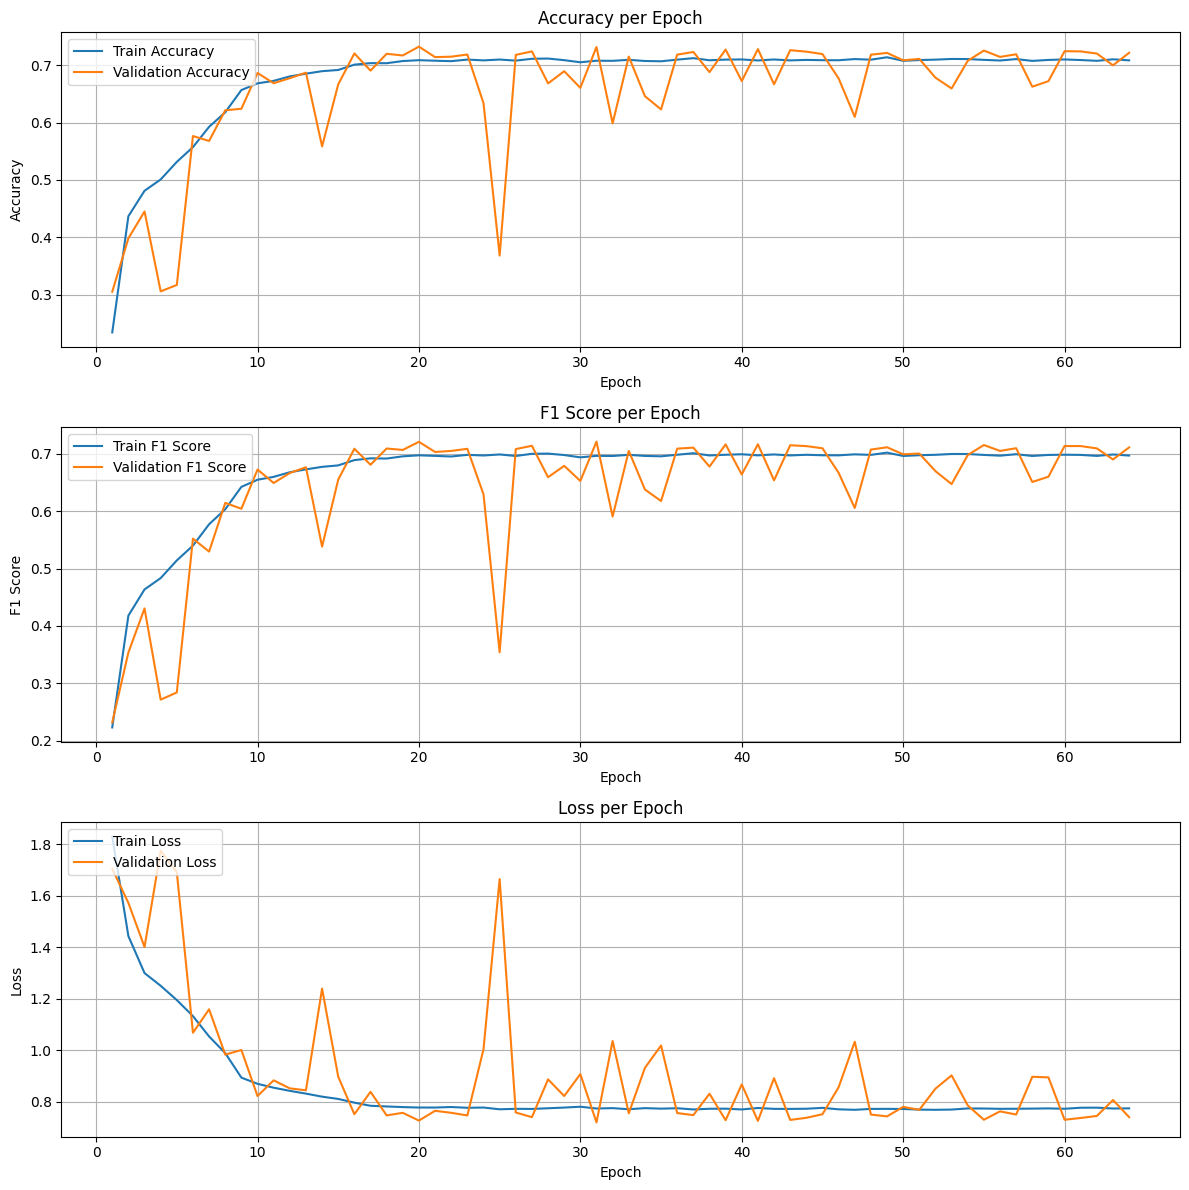

In [372]:
model_name = 'model_resnet_2'
path = '/content/drive/MyDrive/ADV_ML/'
results_resnet2 = train_model(model_resnet2, optimizer, exp_lr_scheduler, train_loader, val_loader,model_name, 64, path)

##let's try to use augementation on our dataset . we will use :